In [1]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq

#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

## **Human Feedback**

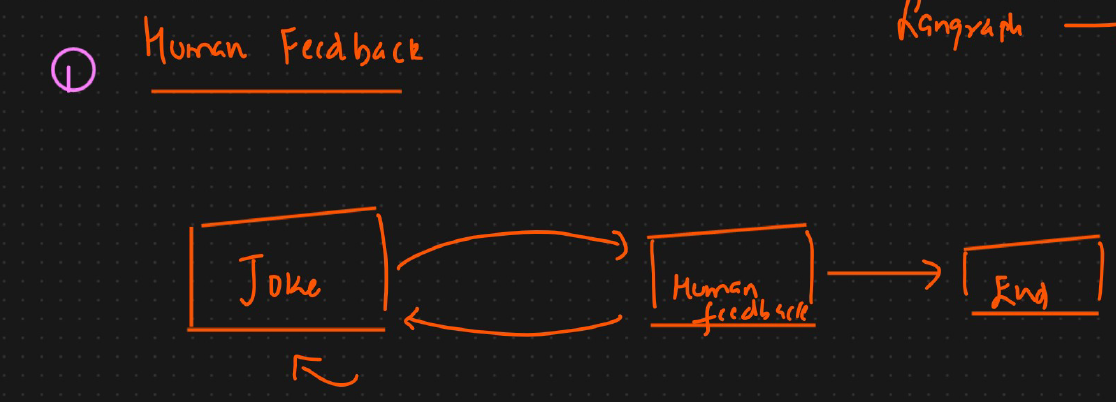

In [2]:
# Define LLM
llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")

result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003668858, 'queue_time': 0.228502528, 'total_time': 0.053668858}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-6b31c93b-4fb5-4b0e-ae1e-1781b1f93e8c-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [3]:
from typing_extensions import TypedDict

class JokeState(TypedDict):
    topic: str
    joke: str
    human_feedback: str

In [4]:
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph


# Create joke_node
def create_joke(state: JokeState):
    if state['human_feedback'] is None:
        msg = llm.invoke(f"Write a short joke about {state['topic']}")
        return {"joke": msg.content}
    else:
        msg = llm.invoke(f"Write a short joke bette than: {state['joke']} for the same topic:{state['topic']}, do not return the same joke")
        return {"joke": msg.content}


# Create Feedback Node with conditional edge
def human_feedback(state: JokeState):
    pass
def should_continue(state: JokeState):
    # Check if human feedback
    human_feedback = state.get("human_feedback", None)
    if human_feedback == "bad":
        return "Create_joke"
    return END

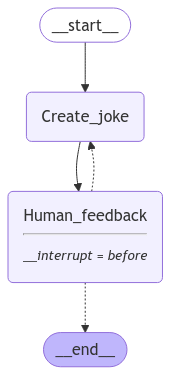

In [5]:
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

# Add nodes and edges 
builder = StateGraph(JokeState)

# Add nodes
builder.add_node("Create_joke", create_joke)
builder.add_node("Human_feedback", human_feedback)

# Add edges
builder.add_edge(START, "Create_joke")
builder.add_edge("Create_joke", "Human_feedback")

# Add conditional edge
builder.add_conditional_edges("Human_feedback", should_continue) # , ['Create_joke', END]

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['Human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

### Output Session 1:

In [6]:
# Thread
thread = {"configurable": {"thread_id": "2"}}
feedback = None
topic = "People"

# Run the graph until the first interruption
for event in graph.stream({"topic":topic, "human_feedback":feedback}, thread, stream_mode="values"):
    print(event)

{'topic': 'People', 'human_feedback': None}
{'topic': 'People', 'joke': 'Why did the person become a math book?\n\nBecause they had a lot of problems!', 'human_feedback': None}


In [7]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": input("Give your feedback: good/bad")}, as_node="Human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff39dc-494b-60e2-8002-00a620cb3634'}}

In [8]:
# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'topic': 'People', 'joke': 'Why did the person become a math book?\n\nBecause they had a lot of problems!', 'human_feedback': 'bad'}
{'topic': 'People', 'joke': 'Why did the person become a geometry book?\n\nBecause they contained all the angles!', 'human_feedback': 'bad'}


In [9]:
state=graph.get_state(thread)
state.next

('Human_feedback',)

In [10]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": None}, as_node="Human_feedback")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff39e0-3e53-62b5-8004-56e42bf80213'}}

In [11]:
state=graph.get_state(thread)
state.next

()

In [12]:
final_state = graph.get_state(thread)
joke = final_state.values.get('joke')

print("The Final Joke is:")
print("-" * 25)
print(joke)

The Final Joke is:
-------------------------
Why did the person become a geometry book?

Because they contained all the angles!


### Output Session 2:

In [13]:
# Thread
thread = {"configurable": {"thread_id": "3"}}
feedback = None
topic = "People"

# Run the graph until the first interruption
for event in graph.stream({"topic":topic, "human_feedback":feedback}, thread, stream_mode="values"):
    print(event)

{'topic': 'People', 'human_feedback': None}
{'topic': 'People', 'joke': 'Why did the person bring a ladder to the party?\n\nBecause they heard the drinks were on the house!', 'human_feedback': None}


In [14]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": input("Give your feedback: good/bad")}, as_node="Human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff39f0-c361-639c-8002-99a45ec94de1'}}

In [15]:
state=graph.get_state(thread)
state.next

()

In [16]:
final_state = graph.get_state(thread)
joke = final_state.values.get('joke')

print("The Final Joke is:")
print("-" * 25)
print(joke)

The Final Joke is:
-------------------------
Why did the person bring a ladder to the party?

Because they heard the drinks were on the house!


### Output Session 3:

In [6]:
# Thread
thread = {"configurable": {"thread_id": "1"}}

# Input
topic = "World"

# Run the graph until the first interruption
for event in graph.stream({"topic":topic}, thread, stream_mode="values"):
    #print(event)
    joke=event.get("joke",'')
    if joke:
        print(joke)
        print("-" * 100)

Why don't scientists trust atoms?

Because they make up everything, even the world!
----------------------------------------------------------------------------------------------------


In [7]:
state=graph.get_state(thread)
state.next

('Human_feedback',)

In [8]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_feedback": input("Give your feedback: good/bad")}, as_node="Human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff3939-904c-6067-8002-939db7b165cd'}}

In [9]:
# Run the graph until the first interruption
for event in graph.stream(None, thread, stream_mode="values"):
    #print(event)
    joke=event.get("joke",'')
    if joke:
        print(joke)
        print("-" * 100)

Why don't scientists trust atoms?

Because they make up everything, even the world!
----------------------------------------------------------------------------------------------------
Why don't scientists trust atoms?

Because they make up everything, even the world!
----------------------------------------------------------------------------------------------------


In [10]:
state=graph.get_state(thread)
state.next

('Human_feedback',)

In [11]:
further_feedack = None

graph.update_state(thread, {"human_feedback": further_feedack}, as_node="Human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff3939-9719-6e5a-8004-406c87fe7b62'}}

In [12]:
state=graph.get_state(thread)
state.next

()

In [13]:
final_state = graph.get_state(thread)
joke = final_state.values.get('joke')

In [14]:
print("The Final Joke is:")
print("-" * 25)
print(joke)

The Final Joke is:
-------------------------
Why don't scientists trust atoms?

Because they make up everything, even the world!
